<a href="https://colab.research.google.com/github/TanushGoel/Gordon-RamsAI/blob/master/Gordon_RamsAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Gordon RamsAI is a seq2seq neural network that is able to generate new step-by-step recipes based on the name of the dish the user wants to make and the ingredients the user would like to include in it

The point of the project to advance AI to the point where one can say "Hey AI, make me a new recipe for ..." or "Hey AI, I have ... ingredients, make me a new recipe that uses them" or "Hey AI, I want to make ... and I have ... ingredients, make me a new recipe"

## Process Data

In [1]:
!unzip -q -o "recipes_data.zip"

# data sources:
# https://www.kaggle.com/shuyangli94/food-com-recipes-and-user-interactions --> Food.com

In [2]:
import pandas as pd

recipes = pd.read_csv("recipes_data/RAW_recipes.csv")
recipes["steps"] = [eval(recipe_steps) for recipe_steps in recipes["steps"]] # convert list-formatted string into a list
recipes["steps"] = [" ".join(steps) for steps in recipes["steps"]] # turn the steps into a single string
recipes["ingredients"] = [eval(ingreds) for ingreds in recipes["ingredients"]] # convert list-formatted string into a list
recipes["ingredients"] = [" ".join(ingreds) for ingreds in recipes["ingredients"]] # turn the steps into a single string
print(len(recipes))
recipes.head()

231637


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,make a choice and proceed with recipe dependin...,autumn is my favorite time of year to cook! th...,winter squash mexican seasoning mixed spice ho...,7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,preheat oven to 425 degrees f press dough into...,this recipe calls for the crust to be prebaked...,prepared pizza crust sausage patty eggs milk s...,6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,brown ground beef in large pot add chopped oni...,this modified version of 'mom's' chili was a h...,ground beef yellow onions diced tomatoes tomat...,13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,place potatoes in a large pot of lightly salte...,"this is a super easy, great tasting, make ahea...",spreadable cheese with garlic and herbs new po...,11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,"mix all ingredients& boil for 2 1 / 2 hours , ...",my dh's amish mother raised him on this recipe...,tomato juice apple cider vinegar sugar salt pe...,8


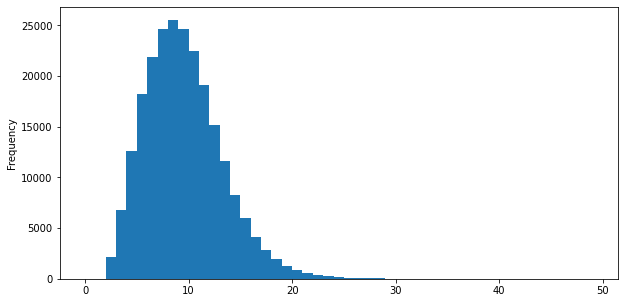

In [3]:
import numpy as np
recipes["n_ingredients"].plot(kind='hist', bins=np.arange(start=0, stop=50, step=1), figsize=[10,5])

In [4]:
interactions = pd.read_csv("recipes_data/RAW_interactions.csv")
print(len(interactions))
interactions.head()

1132367


,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


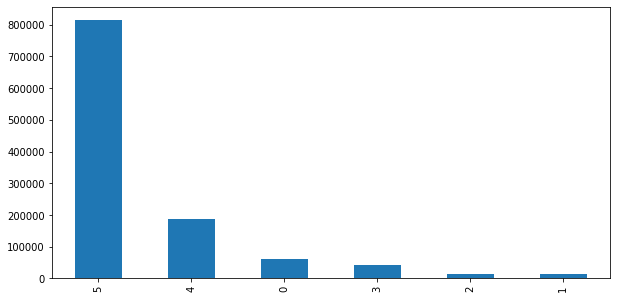

In [5]:
interactions["rating"].value_counts().plot(kind='bar', figsize=[10,5])

In [6]:
averaged_ratings = [] # create averaged ratings for each recipe from the interactions data
for id in recipes.id:
    all_ratings = interactions.loc[interactions['recipe_id'] == id].rating
    averaged_ratings.append(sum(all_ratings) / len(all_ratings))

In [7]:
import string 

data = pd.DataFrame({"name": [str(s).translate(str.maketrans('', '', string.punctuation)).lower() for s in recipes["name"]],
                     "ingredients": [str(s).translate(str.maketrans('', '', string.punctuation)).lower() for s in recipes["ingredients"]],
                     "steps": [str(s).translate(str.maketrans('', '', string.punctuation)).lower() for s in recipes["steps"]],  
                     "rating": averaged_ratings})
data = data[data['rating'] >= 3.00].drop('rating', axis=1) # remove the bad recipes
del recipes, interactions, averaged_ratings
print(len(data))
data.head()

216435


,name,ingredients,steps
0,arriba baked winter squash mexican style,winter squash mexican seasoning mixed spice ho...,make a choice and proceed with recipe dependin...
1,a bit different breakfast pizza,prepared pizza crust sausage patty eggs milk s...,preheat oven to 425 degrees f press dough into...
2,all in the kitchen chili,ground beef yellow onions diced tomatoes tomat...,brown ground beef in large pot add chopped oni...
3,alouette potatoes,spreadable cheese with garlic and herbs new po...,place potatoes in a large pot of lightly salte...
4,amish tomato ketchup for canning,tomato juice apple cider vinegar sugar salt pe...,mix all ingredients boil for 2 1 2 hours or ...


In [8]:
data.drop_duplicates(subset="name", keep=False, inplace=True) 
print(len(data))

213851


In [9]:
import nltk
!python -m nltk.downloader all -q
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

def process_text(text):

    tokens = word_tokenize(text) # break into words
    stemmed = [porter.stem(word) for word in tokens] # stemming reduces a word to its root or base --> “fishing,” “fished,” “fisher” all reduce to the stem “fish”
    stemmed.insert(0, "<start>") # SOS
    stemmed.append("<end>") # EOS
    
    return stemmed

for col in data.columns:
    data[col] = data[col].apply(process_text)

data.to_csv("gordon_ramsAI_data.csv", index=False)

data.head()

,name,ingredients,steps
0,"[<start>, arriba, bake, winter, squash, mexica...","[<start>, winter, squash, mexican, season, mix...","[<start>, make, a, choic, and, proceed, with, ..."
1,"[<start>, a, bit, differ, breakfast, pizza, <e...","[<start>, prepar, pizza, crust, sausag, patti,...","[<start>, preheat, oven, to, 425, degre, f, pr..."
2,"[<start>, all, in, the, kitchen, chili, <end>]","[<start>, ground, beef, yellow, onion, dice, t...","[<start>, brown, ground, beef, in, larg, pot, ..."
3,"[<start>, alouett, potato, <end>]","[<start>, spreadabl, chees, with, garlic, and,...","[<start>, place, potato, in, a, larg, pot, of,..."
4,"[<start>, amish, tomato, ketchup, for, canning...","[<start>, tomato, juic, appl, cider, vinegar, ...","[<start>, mix, all, ingredi, boil, for, 2, 1, ..."


In [10]:
print(data.steps.iloc[0])

['<start>', 'make', 'a', 'choic', 'and', 'proceed', 'with', 'recip', 'depend', 'on', 'size', 'of', 'squash', 'cut', 'into', 'half', 'or', 'fourth', 'remov', 'seed', 'for', 'spici', 'squash', 'drizzl', 'oliv', 'oil', 'or', 'melt', 'butter', 'over', 'each', 'cut', 'squash', 'piec', 'season', 'with', 'mexican', 'season', 'mix', 'ii', 'for', 'sweet', 'squash', 'drizzl', 'melt', 'honey', 'butter', 'grate', 'piloncillo', 'over', 'each', 'cut', 'squash', 'piec', 'season', 'with', 'sweet', 'mexican', 'spice', 'mix', 'bake', 'at', '350', 'degre', 'again', 'depend', 'on', 'size', 'for', '40', 'minut', 'up', 'to', 'an', 'hour', 'until', 'a', 'fork', 'can', 'easili', 'pierc', 'the', 'skin', 'be', 'care', 'not', 'to', 'burn', 'the', 'squash', 'especi', 'if', 'you', 'opt', 'to', 'use', 'sugar', 'or', 'butter', 'if', 'you', 'feel', 'more', 'comfort', 'cover', 'the', 'squash', 'with', 'aluminum', 'foil', 'the', 'first', 'half', 'hour', 'give', 'or', 'take', 'of', 'bake', 'if', 'desir', 'season', 'with

# Data

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv("gordon_ramsAI_data.csv")
for col in data.columns:
    data[col] = data[col].apply(eval)
data.head()

,name,ingredients,steps
0,"[<start>, arriba, bake, winter, squash, mexica...","[<start>, winter, squash, mexican, season, mix...","[<start>, make, a, choic, and, proceed, with, ..."
1,"[<start>, a, bit, differ, breakfast, pizza, <e...","[<start>, prepar, pizza, crust, sausag, patti,...","[<start>, preheat, oven, to, 425, degre, f, pr..."
2,"[<start>, all, in, the, kitchen, chili, <end>]","[<start>, ground, beef, yellow, onion, dice, t...","[<start>, brown, ground, beef, in, larg, pot, ..."
3,"[<start>, alouett, potato, <end>]","[<start>, spreadabl, chees, with, garlic, and,...","[<start>, place, potato, in, a, larg, pot, of,..."
4,"[<start>, amish, tomato, ketchup, for, canning...","[<start>, tomato, juic, appl, cider, vinegar, ...","[<start>, mix, all, ingredi, boil, for, 2, 1, ..."


In [2]:
vocab = []
for text in data.name:
    vocab += text
vocab = list(set(vocab))
word_to_int_name = dict(zip(vocab, range(1, len(vocab)+1)))
int_to_word_name = {v: k for k, v in word_to_int_name.items()}
num_words_name = len(vocab)+1 # add one for padding 0's
print(num_words_name-1, "words in name vocab")

vocab = []
for text in data.ingredients:
    vocab += text
vocab = list(set(vocab))
word_to_int_ingreds = dict(zip(vocab, range(1, len(vocab)+1)))
int_to_word_ingreds = {v: k for k, v in word_to_int_ingreds.items()}
num_words_ingreds = len(vocab)+1 # add one for padding 0's
print(num_words_ingreds-1, "words in ingredients vocab")

vocab = []
for text in data.steps:
    vocab += text
vocab = list(set(vocab))
word_to_int_steps = dict(zip(vocab, range(1, len(vocab)+1)))
int_to_word_steps = {v: k for k, v in word_to_int_steps.items()}
num_words_steps = len(vocab)+1 # add one for padding 0's
print(num_words_steps-1, "words in steps vocab")

del vocab

23390 words in name vocab
3901 words in ingredients vocab
42840 words in steps vocab


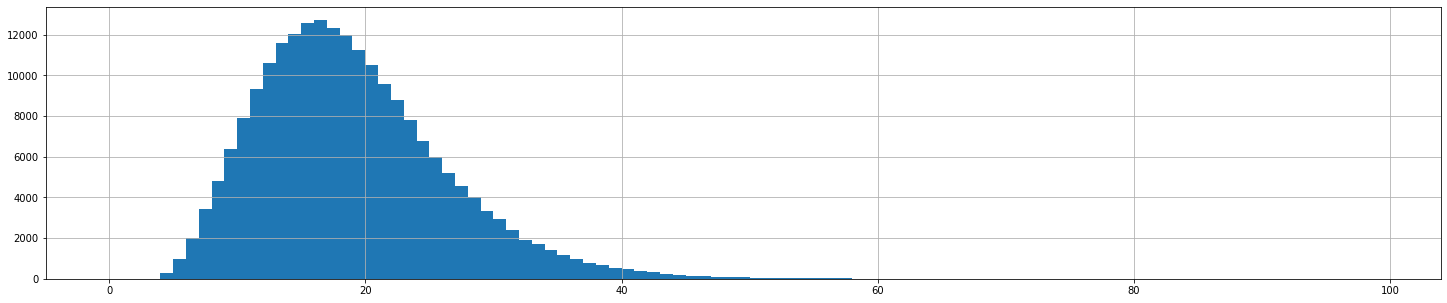

In [4]:
# visualize amount of words in recipe names
pd.DataFrame([len(text) for text in data.ingredients])[0].hist(bins=np.arange(start=0, stop=100, step=1), figsize=[25,5])

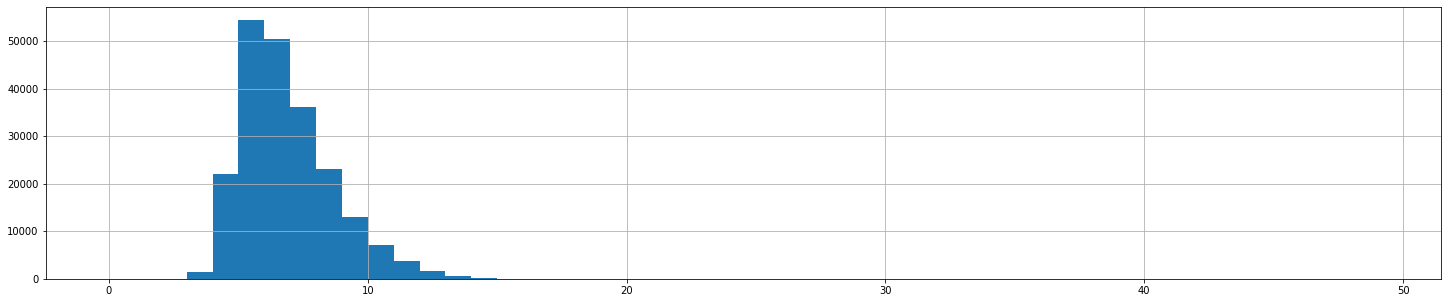

In [3]:
# visualize amount of words in recipe names
pd.DataFrame([len(text) for text in data.name])[0].hist(bins=np.arange(start=0, stop=50, step=1), figsize=[25,5])

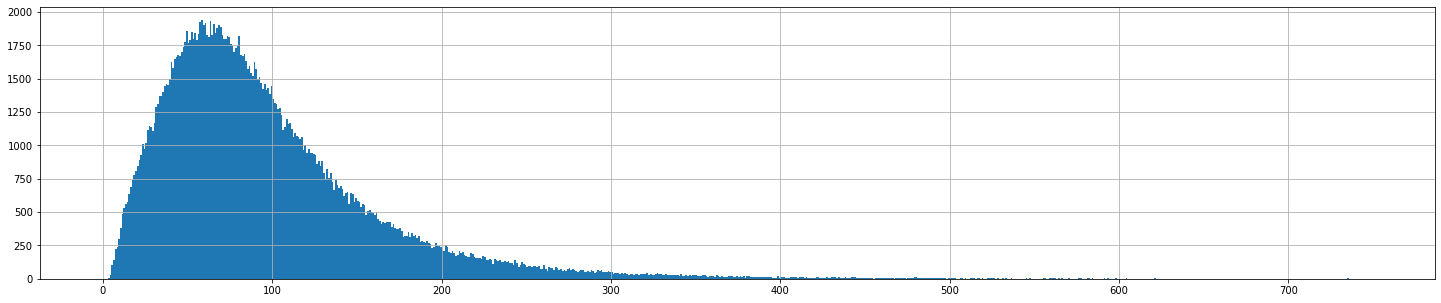

In [5]:
# visualize amount of words in recipe steps
pd.DataFrame([len(text) for text in data.steps])[0].hist(bins=np.arange(start=0, stop=750, step=1), figsize=[25,5])

In [6]:
max_name_len = 16
max_ingreds_len = 64
max_steps_len = 256

data = data[data['name'].str.len().le(max_name_len)] 
data = data[data['ingredients'].str.len().le(max_ingreds_len)] 
data = data[data['steps'].str.len().le(max_steps_len)] 
len(data)

207414

In [7]:
print(data.name.map(lambda x: len(x)).max()) # max_name_len
print(data.ingredients.map(lambda x: len(x)).max()) # max_ingreds_len
print(data.steps.map(lambda x: len(x)).max()) # max_steps_len

16
64
256


# Models

## CerberusNet 
- transformer-based model - no multi-headed attention

## ForkNet
- bidirectional lstm model




In [8]:
# CerberusNet

import tensorflow as tf

def get_angles(pos, i, d_model):

    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):

    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
      
    pos_encoding = angle_rads[np.newaxis, ...]
      
    return tf.cast(pos_encoding, dtype=tf.float32)

d_model = 128
dff = 256
maximum_position_encoding = 10000

scaling_factor = tf.keras.backend.constant(np.sqrt(d_model), shape = (1,1,1))

# Encoders

## name
name_input = tf.keras.layers.Input(shape=(max_name_len,), dtype='int32', name="name_in")

x = tf.keras.layers.Embedding(num_words_name, d_model)(name_input)

x = tf.keras.layers.Dropout(0.0125)(x) # hides parts of the name of the dish to force the model to learn to make assumptions about what can be made with certain ingredients

x = tf.keras.layers.Multiply()([x, scaling_factor])
pos = positional_encoding(maximum_position_encoding, d_model)
x = tf.keras.layers.Add()([x, pos[: , :tf.shape(x)[1], :]] )

query = tf.keras.layers.Dense(d_model)(x)
value = tf.keras.layers.Dense(d_model)(x)
key = tf.keras.layers.Dense(d_model)(x)
attention = tf.keras.layers.Attention()([query, value, key]) 
attention = tf.keras.layers.Dense(d_model)(attention)

x = tf.keras.layers.Add()([x, attention])
x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

dense = tf.keras.layers.Dense(dff, activation=tf.keras.activations.swish)(x)
dense = tf.keras.layers.Dense(d_model)(dense)
x = tf.keras.layers.Add()([x, dense]) 
encoder_name = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

## ingredients 
ingreds_input = tf.keras.layers.Input(shape=(max_ingreds_len,), dtype='int32', name="ingreds_in")

x = tf.keras.layers.Embedding(num_words_ingreds, d_model)(ingreds_input)

x = tf.keras.layers.Dropout(0.025)(x) # hides some of the ingredients to force the model to learn to make assumptions about what should be in each dish

x = tf.keras.layers.Multiply()([x, scaling_factor])
pos = positional_encoding(maximum_position_encoding, d_model)
x = tf.keras.layers.Add()([x, pos[: , :tf.shape(x)[1], :]] )

query = tf.keras.layers.Dense(d_model)(x)
value = tf.keras.layers.Dense(d_model)(x)
key = tf.keras.layers.Dense(d_model)(x)
attention = tf.keras.layers.Attention()([query, value, key])
attention = tf.keras.layers.Dense(d_model)(attention)

x = tf.keras.layers.Add()([x, attention])
x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

dense = tf.keras.layers.Dense(dff, activation=tf.keras.activations.swish)(x)
dense = tf.keras.layers.Dense(d_model)(dense)
x = tf.keras.layers.Add()([x, dense]) 
encoder_ingreds = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

# Decoder

target = tf.keras.layers.Input(shape=(max_steps_len,), dtype='int32', name="steps_in")

x = tf.keras.layers.Embedding(num_words_steps, d_model)(target)

x = tf.keras.layers.Multiply()([x, scaling_factor])
pos = positional_encoding(maximum_position_encoding, d_model)
x = tf.keras.layers.Add()([x, pos[: , :tf.shape(x)[1], :] ])

query = tf.keras.layers.Dense(d_model)(x)
value = tf.keras.layers.Dense(d_model)(x)
key = tf.keras.layers.Dense(d_model)(x)
attention = tf.keras.layers.Attention(causal = True)([query, value, key])
attention = tf.keras.layers.Dense(d_model)(attention)

x = tf.keras.layers.Add()([x, attention]) 
y = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

query = tf.keras.layers.Dense(d_model)(y)
value = tf.keras.layers.Dense(d_model)(encoder_ingreds)
key = tf.keras.layers.Dense(d_model)(encoder_ingreds)
attention = tf.keras.layers.Attention()([query, value, key])
attention = tf.keras.layers.Dense(d_model)(attention)

x = tf.keras.layers.Add()([y, attention]) 
decode1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

query = tf.keras.layers.Dense(d_model)(y)
value = tf.keras.layers.Dense(d_model)(encoder_name)
key = tf.keras.layers.Dense(d_model)(encoder_name)
attention = tf.keras.layers.Attention()([query, value, key])
attention = tf.keras.layers.Dense(d_model)(attention)

x = tf.keras.layers.Add()([y, attention]) 
decode2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

decoder = tf.keras.layers.concatenate([decode1, decode2])

x = tf.keras.layers.GlobalAveragePooling1D()(decoder)
x = tf.keras.layers.Dense(dff, activation=tf.keras.activations.swish)(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(num_words_steps, activation="softmax", name="output")(x)

model = tf.keras.models.Model(inputs=[name_input, ingreds_input, target], outputs=x)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ingreds_in (InputLayer)         [(None, 64)]         0                                            
__________________________________________________________________________________________________
name_in (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 64, 128)      499456      ingreds_in[0][0]                 
__________________________________________________________________________________________________
embedding (Embedding)           (None, 16, 128)      2994048     name_in[0][0]                    
_______________________________________________________________________________________

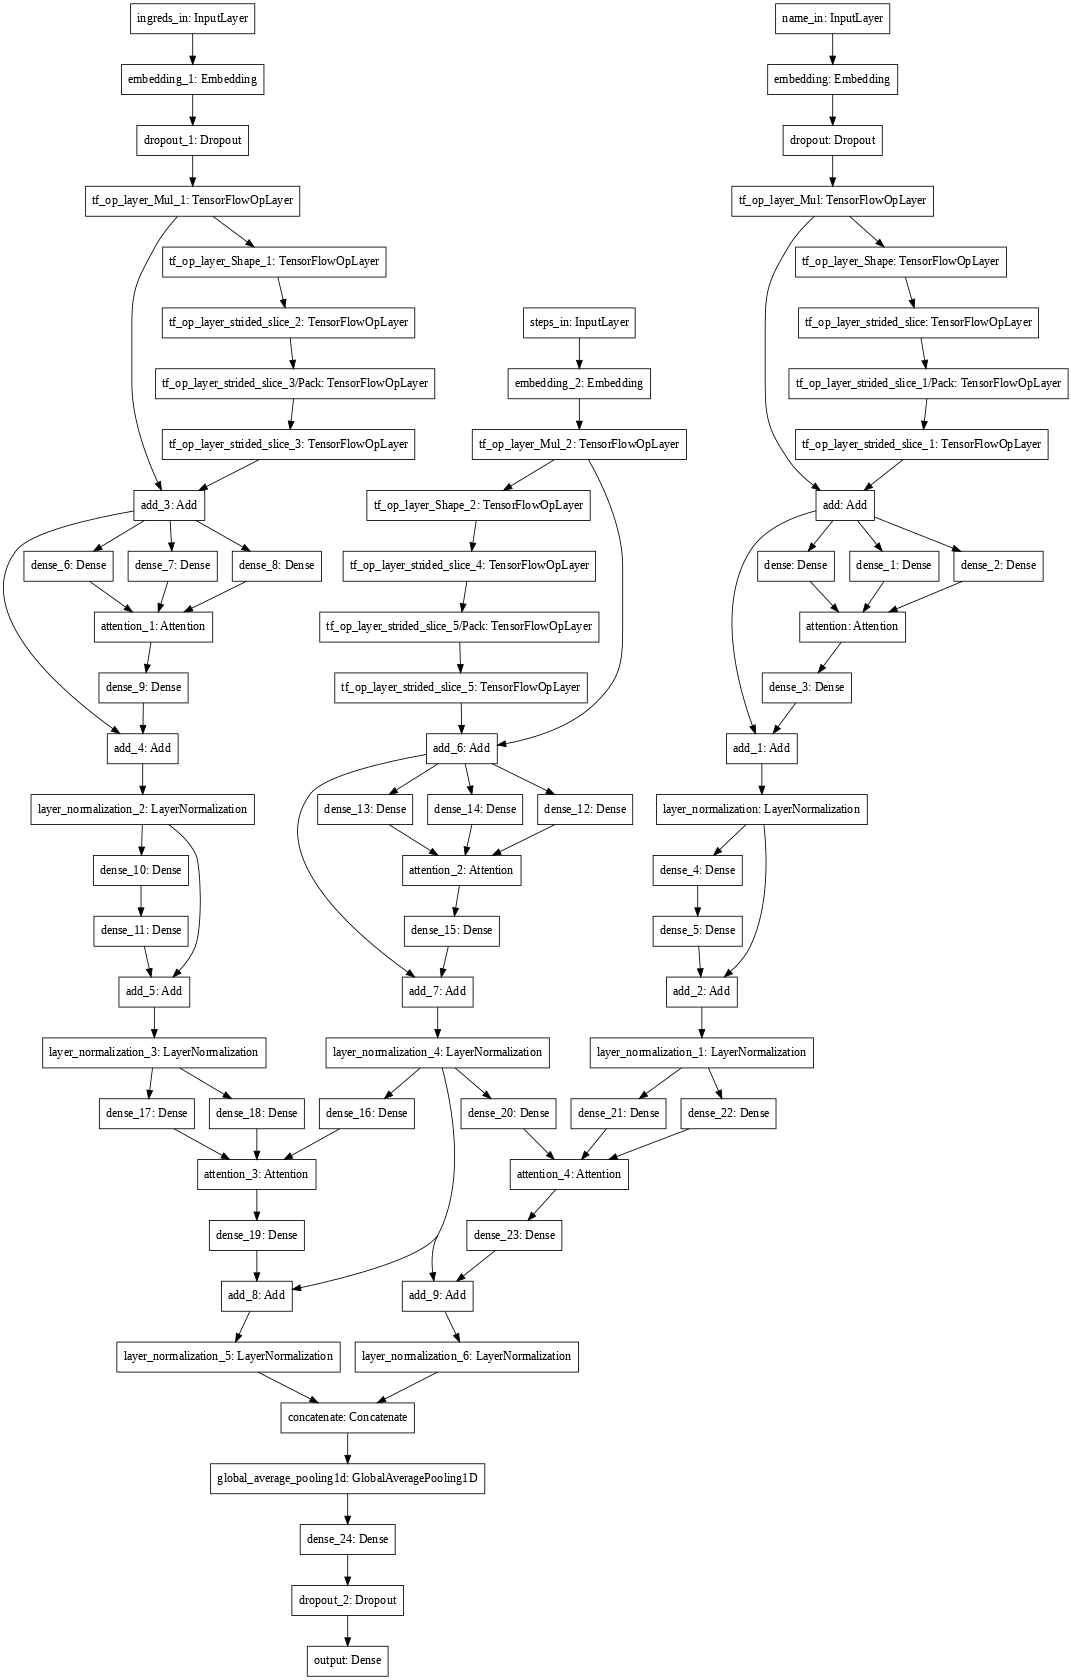

In [9]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=60)

In [14]:
# ForkNet with self-weighted attention

import tensorflow as tf

# self weighted attention
def attention_block(prev_layer): 

    # prev_layer.shape = (batch_size, time_steps, input_dim)

    time_steps = prev_layer.shape[1]
    input_dim = prev_layer.shape[2]

    x = tf.keras.layers.Permute((2, 1))(prev_layer) # (batch_size, input_dim, time_steps)
    x = tf.keras.layers.Dense(time_steps, activation='softmax')(x) # attention matrix
    x = tf.keras.layers.Permute((2, 1))(x) # (batch_size, time_steps, input_dim)

    self_weighted_attention = tf.keras.layers.Multiply()([prev_layer, x])

    return self_weighted_attention

name_input = tf.keras.layers.Input(shape=(max_name_len,), dtype='int32', name='name_in')
# encode the input sequence into a sequence of dense n-dimensional vectors
name_embed = tf.keras.layers.Embedding(output_dim=64, input_dim=num_words_name, input_length=max_name_len)(name_input) 
name_dropout = tf.keras.layers.Dropout(0.025)(name_embed) # hides parts of the name of the dish to force the model to learn to make assumptions about what can be made with certain ingredients

lstm_name_encoder = tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(64, return_sequences=True, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.25), bias_initializer=tf.keras.initializers.Zeros()))(name_dropout)

ingreds_input = tf.keras.layers.Input(shape=(max_ingreds_len,), dtype='int32', name='ingreds_in')
# encode the input sequence into a sequence of dense n-dimensional vectors
ingreds_embed = tf.keras.layers.Embedding(output_dim=16, input_dim=num_words_ingreds, input_length=max_ingreds_len)(ingreds_input) 
ingreds_dropout = tf.keras.layers.Dropout(0.075)(ingreds_embed) # hides some of the ingredients to force the model to learn to make assumptions about what should be in each dish

lstm_ingreds_encoder = tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(64, return_sequences=True, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.25), bias_initializer=tf.keras.initializers.Zeros()))(ingreds_dropout)

steps_input = tf.keras.layers.Input(shape=(max_steps_len,), dtype='int32', name='steps_in')
# encode the input sequence into a sequence of dense n-dimensional vectors
embed_steps = tf.keras.layers.Embedding(output_dim=128, input_dim=num_words_steps, input_length=max_name_len)(steps_input) 

# concat encoder output with steps embeddings
concat = tf.keras.layers.concatenate([lstm_name_encoder, lstm_ingreds_encoder, embed_steps], axis=1)

# use LSTM to transform the vector sequence into a single vector containing information about the entire sequence
lstm1_decoder = tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(64, return_sequences=True, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.25), bias_initializer=tf.keras.initializers.Zeros()))(concat)
lstm1_att = attention_block(lstm1_decoder)
lstm2_decoder = tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(128, return_sequences=True, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.25), bias_initializer=tf.keras.initializers.Zeros()))(lstm1_att)
lstm2_att = attention_block(lstm2_decoder)
lstm3_decoder = tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(64, return_sequences=True, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.25), bias_initializer=tf.keras.initializers.Zeros()))(lstm2_att)
lstm3_att = attention_block(lstm3_decoder)

# turn into vectors
lstm_vec = tf.keras.layers.GlobalAveragePooling1D()(lstm3_att)

# dense layers 
dense1 = tf.keras.layers.Dense(512, activation=tf.keras.activations.swish)(lstm_vec)
dropout1_dense = tf.keras.layers.Dropout(0.1)(dense1)
dense2 = tf.keras.layers.Dense(256, activation=tf.keras.activations.swish)(dropout1_dense)

# output
output = tf.keras.layers.Dense(num_words_steps, activation="softmax", name='output')(dense2) 

model = tf.keras.models.Model(inputs=[name_input, ingreds_input, steps_input], outputs=[output])

model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
name_in (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
ingreds_in (InputLayer)         [(None, 64)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 16, 64)       1497024     name_in[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 64, 16)       62432       ingreds_in[0][0]                 
_______________________________________________________________________________________

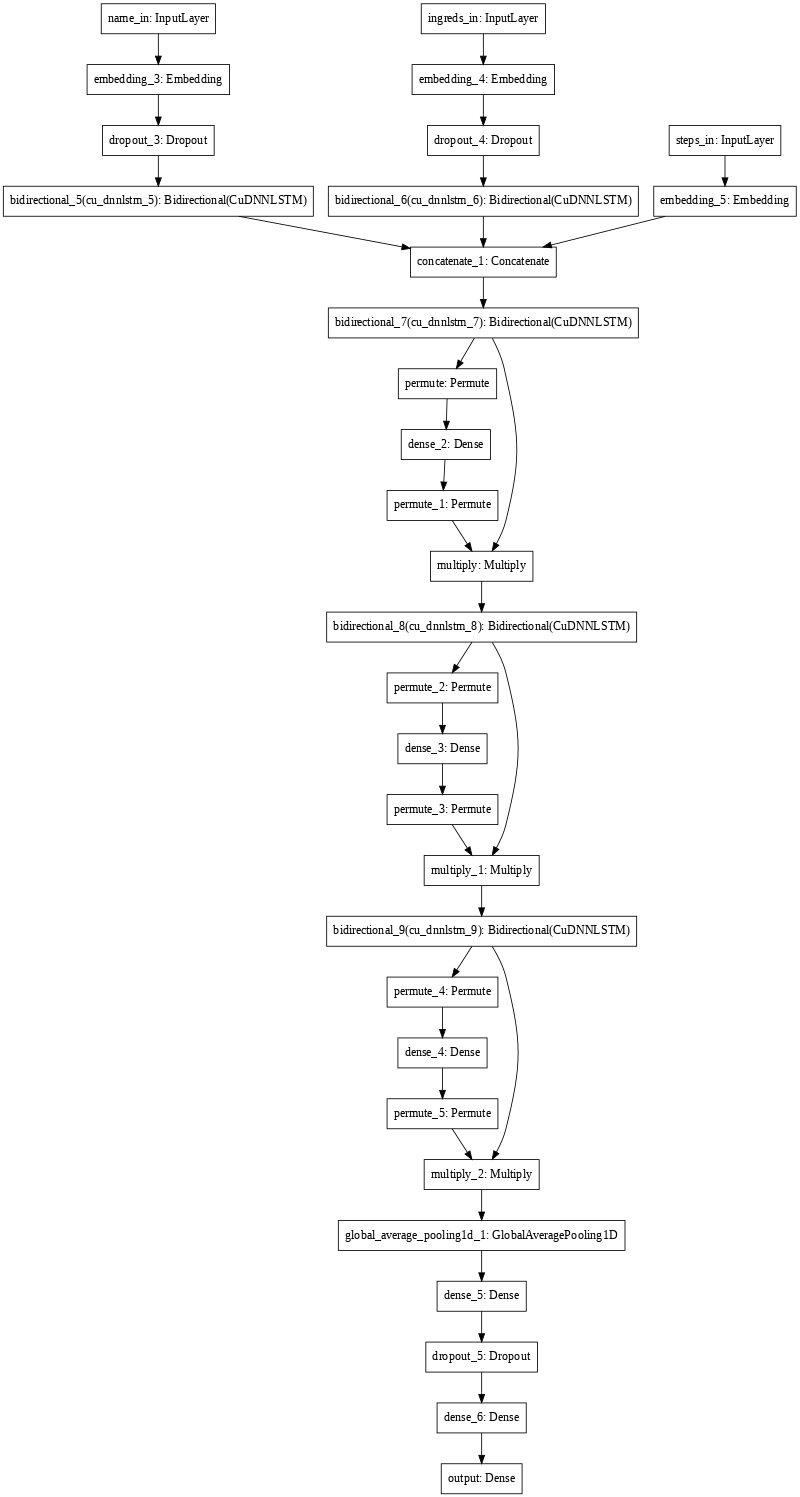

In [15]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=60)

In [8]:
# ForkNet

import tensorflow as tf

name_input = tf.keras.layers.Input(shape=(max_name_len,), dtype='int32', name='name_in')
# encode the input sequence into a sequence of dense n-dimensional vectors
name_embed = tf.keras.layers.Embedding(output_dim=64, input_dim=num_words_name, input_length=max_name_len)(name_input) 
name_dropout = tf.keras.layers.Dropout(0.025)(name_embed) # hides parts of the name of the dish to force the model to learn to make assumptions about what can be made with certain ingredients

lstm_name_encoder = tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(64, return_sequences=True, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.25), bias_initializer=tf.keras.initializers.Zeros()))(name_dropout)

ingreds_input = tf.keras.layers.Input(shape=(max_ingreds_len,), dtype='int32', name='ingreds_in')
# encode the input sequence into a sequence of dense n-dimensional vectors
ingreds_embed = tf.keras.layers.Embedding(output_dim=16, input_dim=num_words_ingreds, input_length=max_ingreds_len)(ingreds_input) 
ingreds_dropout = tf.keras.layers.Dropout(0.075)(ingreds_embed) # hides some of the ingredients to force the model to learn to make assumptions about what should be in each dish

lstm_ingreds_encoder = tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(64, return_sequences=True, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.25), bias_initializer=tf.keras.initializers.Zeros()))(ingreds_dropout)

steps_input = tf.keras.layers.Input(shape=(max_steps_len,), dtype='int32', name='steps_in')
# encode the input sequence into a sequence of dense n-dimensional vectors
embed_steps = tf.keras.layers.Embedding(output_dim=128, input_dim=num_words_steps, input_length=max_name_len)(steps_input) 

# concat encoder output with steps embeddings
concat = tf.keras.layers.concatenate([lstm_name_encoder, lstm_ingreds_encoder, embed_steps], axis=1)

# use LSTM to transform the vector sequence into a single vector containing information about the entire sequence
lstm1_decoder = tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(64, return_sequences=True, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.25), bias_initializer=tf.keras.initializers.Zeros()))(concat)
lstm2_decoder = tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(128, return_sequences=True, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.25), bias_initializer=tf.keras.initializers.Zeros()))(lstm1_decoder)
lstm3_decoder = tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(64, return_sequences=True, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.25), bias_initializer=tf.keras.initializers.Zeros()))(lstm2_decoder)

# turn into vectors
lstm_vec = tf.keras.layers.GlobalAveragePooling1D()(lstm3_decoder)

# dense layers 
dense1 = tf.keras.layers.Dense(512, activation=tf.keras.activations.swish)(lstm_vec)
dropout1_dense = tf.keras.layers.Dropout(0.1)(dense1)
dense2 = tf.keras.layers.Dense(256, activation=tf.keras.activations.swish)(dropout1_dense)

# output
output = tf.keras.layers.Dense(num_words_steps, activation="softmax", name='output')(dense2) 

model = tf.keras.models.Model(inputs=[name_input, ingreds_input, steps_input], outputs=[output])

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
name_in (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
ingreds_in (InputLayer)         [(None, 64)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 16, 64)       1497024     name_in[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 64, 16)       62432       ingreds_in[0][0]                 
_______________________________________________________________________________________

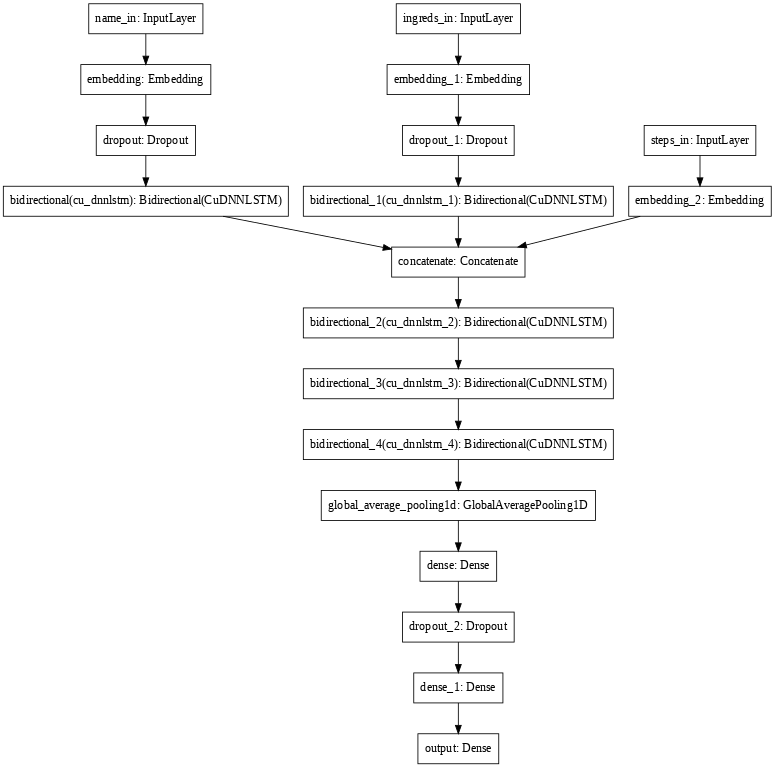

In [9]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=60)

In [10]:
model.compile(optimizer = 'adam', 
              loss = {'output': 'categorical_crossentropy'},
              metrics = {'output': "accuracy"}) 

# Train

In [11]:
def make_sequence_name(text):

    seqs = []
    for words in text:
        seq = [word_to_int_name[word] for word in words]
        while len(seq) != max_name_len:
            seq.append(0)
        seqs.append(seq)
    return seqs

def make_sequence_ingreds(text):

    seqs = []
    for words in text:
        seq = [word_to_int_ingreds[word] for word in words]
        while len(seq) != max_ingreds_len:
            seq.append(0)
        seqs.append(seq)
    return seqs

def make_sequence_steps(text):

    seqs = []
    for words in text:
        seq = [word_to_int_steps[word] for word in words]
        while len(seq) != max_steps_len:
            seq.append(0)
        seqs.append(seq)
    return seqs

In [12]:
batch_siz = 24576

def make_data(df, start1, start2):

    last = False
    steps_broken = []
    next_words = []
    names = []
    ingreds = []
    for idx in range(start1, len(df)): # start from where left off until end of data
        steps = df.steps.iloc[idx] # ["<start>", "preheat", "oven", ... , "<end>"]
        for cutoff in range(start2, len(steps)-1): # start from where left off until end of recipe steps word list
            if len(steps_broken) < batch_siz:
                steps_broken.append(steps[:cutoff+1]) # [["<start>"], ["<start>", "preheat"], ["<start>", "preheat", "oven"], ..., ["<start>", "preheat", "oven", ...]] # does not include EOS
                next_words.append(steps[cutoff+1]) # ["preheat", "oven", ... , "<end>"] # does not include SOS
                names.append(df.name.iloc[idx]) # [[<start>, dutch, leek, casserol, <end>], [<start>, dutch, leek, casserol, <end>], [<start>, dutch, leek, casserol, <end>], ...]
                ingreds.append(df.ingredients.iloc[idx]) # [[<start>, banana, mango, bread, <end>], [<start>, banana, mango, bread, <end>], [<start>, banana, mango, bread, <end>], ...]
            else:
                return names, ingreds, steps_broken, next_words, idx, cutoff, last
        start2 = 0

    last = True
    return names, ingreds, steps_broken, next_words, idx, cutoff, last

In [ ]:
epochs = 1

for epoch in range(epochs): 

    data = data.sample(frac=1).reset_index(drop=True) # shuffle dataframe

    print("\nStarting Epoch:", epoch+1)

    start1 = 0
    start2 = 0
    batch = 1
    last = False
    while not last:

        print("Batch:", batch)
        batch+=1

        names, ingreds, steps, next_words, start1, start2, last = make_data(data, start1, start2)

        names = np.array(make_sequence_name(names), dtype="int32") 
        ingreds = np.array(make_sequence_ingreds(ingreds), dtype="int32")
        steps = np.array(make_sequence_steps(steps), dtype="int32")
        next_words = tf.keras.utils.to_categorical([word_to_int_steps[word] for word in next_words], num_classes=num_words_steps, dtype='int32')

        model.fit({'name_in': names,
                   'ingreds_in': ingreds, 
                   'steps_in': steps},
                  {'output': next_words},
                  shuffle=True, 
                  epochs=1, 
                  batch_size=128)

In [ ]:
model.save_weights("gordon-ramsAI.hdf5")
from google.colab import files
files.download("gordon-ramsAI.hdf5")

# Make New Recipes

In [61]:
import string
import nltk
!python -m nltk.downloader all -q
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

!pip3 install -q gingerit
from gingerit.gingerit import GingerIt
parser = GingerIt()

def process_text(text):

    tokens = word_tokenize(text) # break into words
    stemmed = [porter.stem(word) for word in tokens] # stemming reduces a word to its root or base --> “fishing,” “fished,” “fisher” all reduce to the stem “fish”
    stemmed.insert(0, "<start>") # SOS
    stemmed.append("<end>") # EOS
    
    return stemmed

def make_recipe(name, ingreds):

    name = name.translate(str.maketrans('', '', string.punctuation)).lower()

    name_in = process_text(name)

    if len(name_in) > max_name_len:
        print("name length too long")
        return

    try:
        name_in = [word_to_int_name[word] for word in name_in]
    except:
        print("oops, one of the words entered is not in my vocabulary")
        return

    while len(name_in) != max_name_len:
        name_in.append(0)
    name_in = np.array(name_in, dtype="int32")

    ingreds = ingreds.translate(str.maketrans('', '', string.punctuation)).lower()

    ingreds_in = process_text(ingreds)

    if len(ingreds_in) > max_ingreds_len:
        print("ingredients length too long")
        return

    try:
        ingreds_in = [word_to_int_ingreds[word] for word in ingreds_in]
    except:
        print("oops, one of the words entered is not in my vocabulary")
        return

    while len(ingreds_in) != max_ingreds_len:
        ingreds_in.append(0)
    ingreds_in = np.array(ingreds_in, dtype="int32")

    steps_in = np.zeros(max_steps_len, dtype="int32")
    steps_in[0] = word_to_int_steps["<start>"]

    preds = []
    for idx in range(1, max_steps_len):

        pred_int = np.argmax(model.predict({'name_in': name_in.reshape(1, max_name_len,), 
                                            'ingreds_in': ingreds_in.reshape(1, max_ingreds_len,), 
                                            'steps_in': steps_in.reshape(1, max_steps_len,)}))
        next_pred_word = int_to_word_steps[pred_int]

        if next_pred_word == "<end>":
            break
        else:
            preds.append(next_pred_word)

        steps_in[idx] = pred_int
        
    recipe = " ".join(preds)
    try:
        out = parser.parse(recipe)["result"] 
    except:
        out = ""
        for word in recipe.split():
            out+=parser.parse(word)["result"].lower() + " "

    return out

In [62]:
make_recipe("chocolate chip cookie", "chocolate chips, flour, eggs")

'Preheat oven to 350 degrees in a large bowl comb in the flour, sugar bake powder, baking soda and salt, mix well, add the flour mixture to the cream mixture, mix well, add the Chocol chip and mix well pour into the prepared pan, bake for about 20 minutes or until a toothpick inserted in the center come out clean cool for 5 minutes before remove from the pan'